In [1]:
include("../src/models.jl")
include("../src/special.jl")
include("../src/solvers.jl")

using Plots
using ProgressBars
using LinearAlgebra

In [2]:
p = 1000
N = 120
ω = 1.0
ρ = 0.05
τ = 0.5
β = 0.27
T = 15
σ = 1.0
ts = Array{Float64}(0:T*p) / p

ϕ(x) = β*sgn(x)
normdims(X, dims) = sqrt.(sum(X .^ 2, dims=dims))
cossim(X, y) = (X * y) ./ (norm(y) * normdims(X, 2));

In [3]:
Q_mc = zeros((N, T*p+1))
X_mc = zeros((N, T*p+1, p))
Ξ = zeros((N, p))

for n ∈ ProgressBar(1:N)
    ξ, spiked = spikedmodel(ρ, p, ω, σ)
    Ξ[n, :] = ξ
    X = online(spiked, ϕ, τ, T)
    X_mc[n, :, :] = X
    Q_mc[n, :] = cossim(X, ξ')
end

100.0%┣████████████████████████████████████████┫ 120/120 [57:34<00:00, 0.0 it/s]


In [4]:
using JLD

save("../data/oist_mc.jld", "Q_mc", Float32.(Q_mc), 
                           "Xi_mc", Float32.(Ξ), 
                           "X_mc", Float32.(X_mc))

In [6]:
zero_idxs = findall(Ξ .== 0)
X_zeros = permutedims(X_mc, [1, 3, 2])[zero_idxs, :]

sparse_idxs = findall(Ξ .> 0)
X_sparse = permutedims(X_mc, [1, 3, 2])[sparse_idxs, :];

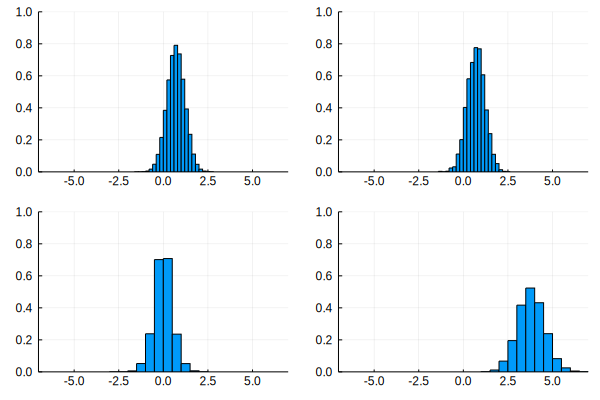

In [18]:
l = @layout [a b; c d]

p11 = histogram(X_zeros[:, 1], normed=true, bins=20)
p12 = histogram(X_sparse[:, 1], normed=true, bins=20)

p21 = histogram(X_zeros[:, end], normed=true, bins=20)
p22 = histogram(X_sparse[:, end], normed=true, bins=20)

plot(p11, p12, p21, p22, leg=false)
ylims!(0, 1)
xlims!(-7, 7)

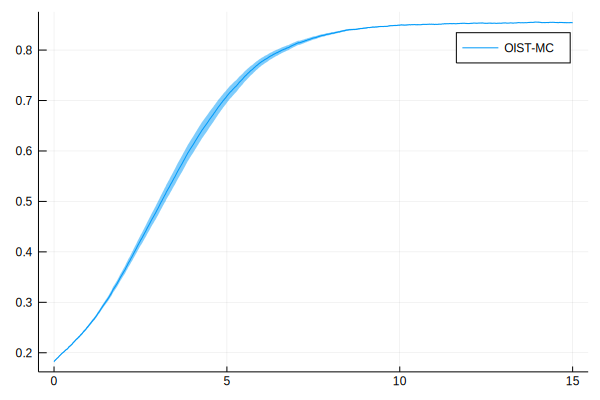

In [27]:
plot(ts, mean(Q_mc, dims=1)[1, :], ribbon=var(Q_mc, dims=1)[1, :], label="OIST-MC")

In [15]:
Γ(x, ξ, Q, R, ϕ) = τ*ω*Q*ξ .- ϕ(x) .- x*(τ*ω*Q^2 - R + (τ^2/2)*(1+ω*Q^2));

In [26]:
using JLD

save("../data/Q_oist_mc.jld", "data", Q_mc)
save("../data/xi_oist_mc.jld", "data", Ξ)
save("../data/x_oist_mc.jld", "data", X_mc)

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1273
